In [2]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [5]:
#Setup paths
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [88]:
#Make the Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [90]:
# Move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    subdirectory_path = os.path.join('lfw', directory)
    if os.path.isdir(subdirectory_path):
        for file in os.listdir(subdirectory_path):
            EX_PATH=os.path.join(subdirectory_path, file)
            NEW_PATH=os.path.join(NEG_PATH, file)
            os.replace(EX_PATH,NEW_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'lfw'

In [8]:
#import uuid library to generate unique image names
import uuid

In [10]:
#Establish a connection to the webcam 
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame=cap.read()
    #cut down frame to 250x250 px
    frame=frame[100:100+250,600:600+250, :]
    #collect anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        # Create the unique file path
        imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
 
    #collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        #Create the unique file path
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #writeout positive image
        cv2.imwrite(imgname, frame)
        
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [12]:
#plt.imshow(frame[100:100+250,600:600+250, :])

In [14]:
#get image directories
anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(400)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(400)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(20000)

In [16]:
dir_test=anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data/anchor/1d6de3e8-dfe6-11ef-a856-de1356da0133.jpg'


In [20]:
def preprocess(file_path):
    #read in image from file path
    byte_img=tf.io.read_file(file_path)
    #Load in the image
    img=tf.io.decode_jpeg(byte_img)
    #pre-processing steps- resizing the image to be 100x100x3
    img=tf.image.resize(img,(100,100))
    #scale the image to be 0 and 1
    img=img/255.0
    return img

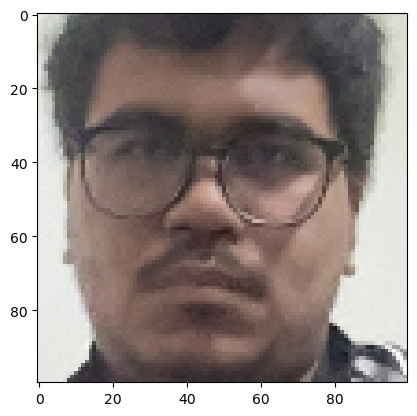

In [22]:
img=preprocess(b'data/anchor/b6e46b7e-dfe5-11ef-a856-de1356da0133.jpg')
plt.imshow(img)

In [24]:
#(anchor,positive)=>1,1,1,1,1
#(anchor,negative)=0,0,0,0,0

In [455]:
tf.ones(len(anchor))

<tf.Tensor: shape=(400,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [28]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data=positives.concatenate(negatives)

In [30]:
samples =data.as_numpy_iterator()

In [32]:
exampple=samples.next()

In [34]:
exampple

(b'data/anchor/7377bb34-dfe5-11ef-a856-de1356da0133.jpg',
 b'data/positive/927dd774-dfe6-11ef-a856-de1356da0133.jpg',
 1.0)

In [36]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [38]:
res=preprocess_twin(*exampple)

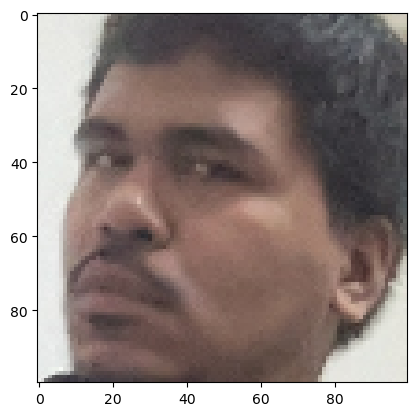

In [457]:
plt.imshow(res[1])

In [42]:
res[2]

1.0

In [44]:
#Build dataloader pipeline
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [46]:
round(len(data)*.7)

560

In [153]:
print(len(data))

800


In [48]:
#Training Partition
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [50]:
train_samples=train_data.as_numpy_iterator()

In [52]:
train_sample=train_samples.next()

In [54]:
len(train_sample[0])

16

In [56]:
#Testing partition
test_data=data.skip(round(len(data)*.3))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [58]:
inp=Input(shape=(100,100,3),name='input_image')

In [60]:
c1=Conv2D(64,(10,10),activation='relu')(inp)
m1=MaxPooling2D(64,(2,2),padding='same')(c1)

In [62]:
c2=Conv2D(128,(7,7),activation='relu')(m1)
m2=MaxPooling2D(64,(2,2),padding='same')(c2)

In [64]:
c3=Conv2D(128,(4,4),activation='relu')(m2)
m3=MaxPooling2D(64,(2,2),padding='same')(c3) 

In [66]:
c4=Conv2D(256,(4,4),activation='relu')(m3)
f1=Flatten()(c4)
d1=Dense(4096, activation='sigmoid')(f1)

In [68]:
mod=Model(inputs=[inp],outputs=[d1],name='embedding')

In [459]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='input_image')
    #first block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    #second block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    #third block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)    
    #final embedding block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096, activation='sigmoid')(f1)
    
   # return Model(inputs=[inp],outputs=[d1],name='embedding')
    return Model(inputs=[inp],outputs=d1,name='embedding')

In [74]:
model=make_embedding()

In [76]:
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Build Distance Layer
# Siamese L1 Distance class
class L1Dist(Layer):
    #Init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
    # Similarity Calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [80]:
l1=L1Dist()

In [82]:
l1    #(anchor_embedding,validation_embedding)

<L1Dist name=l1_dist, built=False>

In [84]:
input_image=Input(name='input_img',shape=(100,100,3))
validation_image=Input(name='validation_img',shape=(100,100,3))

In [86]:
embedding=make_embedding()
inp_embedding=embedding(input_image)
val_embedding=embedding(validation_image)

In [88]:
inp_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_27>

In [90]:
val_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_28>

In [92]:
siamese_layer=L1Dist()

In [94]:
siamese_layer(inp_embedding,val_embedding)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_29>

In [124]:
def make_siamese_model():
    # Anchor image input in the network
    input_image=Input(name='input_img',shape=(100,100,3))
    
    #validation image in the network
    validation_image=Input(name='validation_img',shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    
    #classification layer
    classifier=Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [126]:
siamese_model=make_siamese_model()

In [461]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [132]:
opt=tf.keras.optimizers.Adam(1e-4) #0.0001

In [134]:
#Establishing Checkpoints
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [136]:
#Build Train Step Function
test_batch=train_data.as_numpy_iterator()

In [138]:
batch_1=test_batch.next()

In [140]:
len(batch_1[1])

16

In [142]:
X=batch_1[:2]

In [144]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [146]:
@tf.function
def train_step(batch):

    #Record all of our operations
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        x=batch[:2]
        #Get Label
        y=batch[2]

        # Ensure resizing
        x_resized = [tf.image.resize(img, (100, 100)) for img in x]
        x_resized = tf.stack(x_resized) 
        # Forward pass
        yhat=siamese_model(x,training=True)
        #yhat = siamese_model( x_resized, training=True)
        # Calculate loss
        loss=binary_cross_loss(y,yhat)
   # print(loss)

    # Calculate gradients
    grad=tape.gradient(loss,siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [148]:
# Build Training Loop
def train(data,EPOCHS):
    # Loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx,batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        # Save checkpoints
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [150]:
EPOCHS=50

In [152]:
train(train_data,EPOCHS)


 Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step

 Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step

 Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step

 Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step

 Epoch 5/50


2025-02-13 21:10:10.281020: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step

 Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step

 Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step

 Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step

 Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step

 Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step

 Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step

 Epoch 13/50


2025-02-13 21:29:25.294892: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step

 Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step

 Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step

 Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step

 Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step

 Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step

 Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step

 Epoch 22/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step

 Epoch 23/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step

 Epoch 24/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step

 Epoch 25/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step

 Epoch 26/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step

 Epoch 27/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step

 Epoch 28/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 29/50


2025-02-13 22:07:23.346638: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


35/35 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step

 Epoch 30/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 31/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step

 Epoch 32/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step

 Epoch 33/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 34/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step

 Epoch 35/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step

 Epoch 36/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step

 Epoch 37/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step

 Epoch 38/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step

 Epoch 39/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step

 Epoch 40/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step

 Epoch 41/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step

 Epoch 42/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step

 Epoch 43/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step

 Epoch 44/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step

 Epoch 45/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step

 Epoch 46/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step

 Epoch 47/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1

In [156]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [260]:
#Get a batch of test data
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [262]:
# Make Predictions
y_hat=siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step


array([[1.       ],
       [1.       ],
       [0.999987 ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [0.999922 ],
       [0.9999847],
       [1.       ],
       [1.       ]], dtype=float32)

In [264]:
#Post processing the results
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [266]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [268]:
# Creating a metric object
m=Recall()

#Calculating the recall value
m.update_state(y_true,y_hat)

#Return Recall Result
m.result().numpy()

1.0

In [270]:
# Creating a metric object
m=Precision()

#Calculating the recall value
m.update_state(y_true,y_hat)

#Return Recall Result
m.result().numpy()

1.0

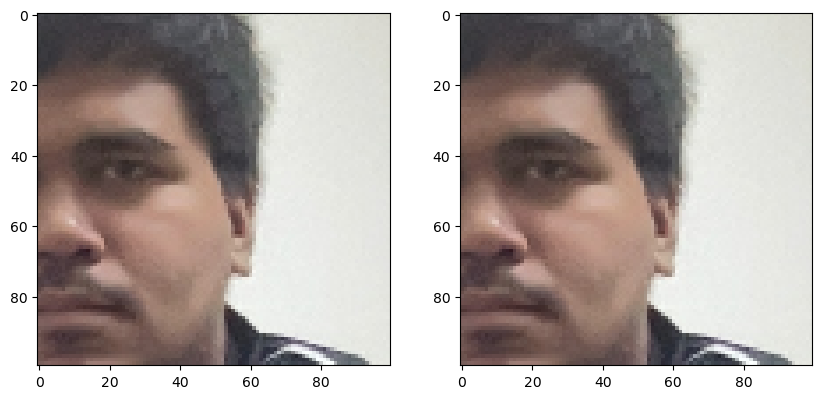

In [272]:
# Set Plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_input[4])

plt.show()

## Save Model

In [279]:
# Save weights
siamese_model.save('siamesemodel.keras')

In [281]:
L1Dist

__main__.L1Dist

In [285]:
# Reload model
model=tf.keras.models.load_model('siamesemodel.keras',
                                 custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [289]:
# Make predictions with reloaded model
model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


array([[1.       ],
       [1.       ],
       [0.999987 ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [0.999922 ],
       [0.9999847],
       [1.       ],
       [1.       ]], dtype=float32)

In [291]:
# view model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Real Test

In [554]:
os.listdir(os.path.join('application_data','verification_images'))

['98ed2f92-dfe6-11ef-a856-de1356da0133.jpg',
 '67c4f0e8-dfe7-11ef-a856-de1356da0133.jpg',
 '5f20aad6-dfe7-11ef-a856-de1356da0133.jpg',
 '9e1726e4-dfe6-11ef-a856-de1356da0133.jpg',
 'dd70259c-dfe7-11ef-a856-de1356da0133.jpg',
 'df7c90dc-dfe7-11ef-a856-de1356da0133.jpg',
 '685d932a-dfe7-11ef-a856-de1356da0133.jpg',
 '6b1b5a0c-dfe7-11ef-a856-de1356da0133.jpg',
 'e6adcdd6-dfe6-11ef-a856-de1356da0133.jpg',
 'b7ecf9e4-dfe7-11ef-a856-de1356da0133.jpg',
 '11ef1ed2-dfe7-11ef-a856-de1356da0133.jpg',
 'dd89dc94-dfe7-11ef-a856-de1356da0133.jpg',
 '50509cfa-dfe7-11ef-a856-de1356da0133.jpg',
 'b25845c4-dfe7-11ef-a856-de1356da0133.jpg',
 '64dee794-dfe7-11ef-a856-de1356da0133.jpg',
 'f3267b6c-dfe6-11ef-a856-de1356da0133.jpg',
 'a0a68e86-dfe6-11ef-a856-de1356da0133.jpg',
 '9447709c-dfe6-11ef-a856-de1356da0133.jpg',
 '69bd22f4-dfe6-11ef-a856-de1356da0133.jpg',
 '3f7e42b0-dfe7-11ef-a856-de1356da0133.jpg',
 '639ec9a8-dfe7-11ef-a856-de1356da0133.jpg',
 '48a0d290-dfe7-11ef-a856-de1356da0133.jpg',
 'cb0d0f78

In [563]:
def verify(model,detection_threshold,verification_threshold):
    #Build results array
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img=preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data','verification_images',image))

        # Make Predictions
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
        detection=np.sum(np.array(results) > detection_threshold)
        # Verification Threshold: Proportion of positive predictions/ total positive samples
        verification=detection/len(os.listdir(os.path.join('application_data','verification_images')))
        verified=verification > verification_threshold

        return results,verified



## OpenCV Real Time Verification

In [565]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame=frame[100:100+250,600:600+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image','input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
False


In [573]:
np.sum(np.squeeze(results) > 0.6)

1